# Create Movie Timestamps

Resampling movies to precise timestamps in order to address dropped frames

## Dependencies

In [23]:
import os, stat
import numpy as np
import cv2
import imageio
import utils.run_analysis as ana
import pandas as pd
from pathlib import Path

## Folders

In [24]:
base_dir = '/hmet_data'
data_dir = os.path.join(base_dir, 'raw')
pngs_dir = os.path.join(base_dir,'pngs')
analysis_dir = os.path.join(base_dir, 'analysis')
trial_list_file = './trial_list.csv'
trials = pd.read_csv(trial_list_file)

## Specify Directories

In [25]:
idx = 0
line = trials.iloc[idx]
raw_folder = os.path.join(data_dir, line['folder'], str(line['trial']).zfill(3))
pngs_folder = os.path.join(pngs_dir, str(line['task']).zfill(3), line['subject'], str(line['iter']))
analysis_folder = os.path.join(base_dir, 'analysis', str(line['task']).zfill(3), line['subject'], str(line['iter']))
Path(analysis_folder).mkdir(parents=True, exist_ok=True)
print(raw_folder)
print(pngs_folder)
print(analysis_folder)

/hmet_data/raw/2020_02_26/004
/hmet_data/pngs/phone/ag/1
/hmet_data/analysis/phone/ag/1


In [26]:
ximea_timestamp_file = os.path.join(raw_folder, 'ximea', 'timestamps_ximea.tsv')
ximea_timesync_file = os.path.join(raw_folder, 'ximea', 'timestamp_camsync_ximea.tsv')

## Write Timestamps
We already have timestamps, but we need them to be in the format tha pupil labs expects from a world cam.

In [27]:
def convert_ximea_time_to_unix_time(timestamp_file, sync_file):
    '''
    Convert the ximea camera times to unix timestamps
    Params:
        timestamp_file (str): path to .csv file with ximea timesstamps
        sync_file (str): path to .csv file with sync information
    Returns:
        unix_timestamp_array (2d np array): Unix Timestamps Inferred
    '''
    with open(timestamp_file, 'r') as f:
        ts_table=list(zip(line.strip().split('\t') for line in f))
    ts_table = np.squeeze(np.array(ts_table[1:]).astype(np.double))

    with open(sync_file, 'r') as f:
        sync_table=list(zip(line.strip().split('\t') for line in f))
        
    (unix_pre, cam_pre, _) = np.array(sync_table[1][0][1:]).astype(np.double)
    (unix_post, cam_post, _) = np.array(sync_table[2][0][1:]).astype(np.double)

    #how far off have the computer and camera timestamps drifted?
    t_elapsed_unix = np.double(unix_post) - np.double(unix_pre)
    t_elapsed_cam = np.double(cam_post) - np.double(cam_pre)
    drift = np.abs(t_elapsed_unix - t_elapsed_cam)
    print(f'Time Elapsed: {t_elapsed_unix} seconds')
    print(f'Time Drift pre to post: {drift} seconds')
    
    # We assume here that time.time() in Linux's 0.001s precision is better than camera's.
    # Convert Camera timestamps to Unix timestamps.
    #first convert to [0,1]
    t_cam_converted = (ts_table[:,2] - cam_pre) / (cam_post - cam_pre)
    #then convert to wall time
    t_cam_converted = (t_cam_converted * (unix_post - unix_pre)) + unix_pre
    
    #assume time in camera is linear, and just change offset at pre.
    #t_cam_converted = ts_table[:,2] - ts_table[0,2] + unix_pre
    
    print(f'Start at {t_cam_converted[0]}, end at {t_cam_converted[-1]}')
    
    #add unix time to data
    t_cam_converted = np.append(ts_table, np.expand_dims(t_cam_converted,1),axis=1)
    
    return(t_cam_converted)

In [16]:
#a = np.load(os.path.join(trial_directory,'eye_camera','000','world_timestamps.npy'))
world_timestamps = convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)[:,3]
np.save(os.path.join(analysis_folder, 'world_timestamps.npy'),world_timestamps) 

Time Elapsed: 91.37102216599988 seconds
Time Drift pre to post: 0.009754682000220782 seconds
Start at 2807.7722497216096, end at 2899.147620575348


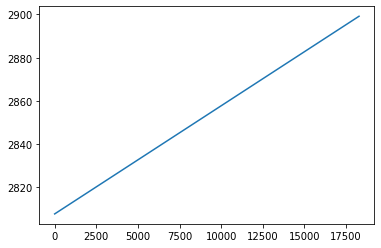

In [17]:
import matplotlib.pyplot as plt
plt.plot(world_timestamps)

## Write Video

In [18]:
number_frames = len([name for name in os.listdir(pngs_dir) if os.path.isfile(os.path.join(pngs_dir,name))])
print(number_frames)

0


In [ ]:
video_filename = os.path.join(analysis_folder, 'world.mp4')
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
video = cv2.VideoWriter(video_filename, fourcc, 200, img_dims[::-1], 1)

for i in range(number_frames):
    frame = imageio.imread(os.path.join(analysis_folder,'pngs',f'frame_{i}.png'))
    frame = frame/np.max(frame)
    video.write(cv2.cvtColor(np.uint8(frame*255), cv2.COLOR_BGR2RGB))
video.release()
print('Done!')

## Function to Loop Through Timestamp convert

In [28]:
def write_ximea_timestamps(trial_directory, analysis_folder, camera):
                           
    ximea_timestamp_file = os.path.join(trial_directory, f'timestamps_ximea.tsv')
    ximea_timesync_file = os.path.join(trial_directory, f'timestamp_camsync_ximea.tsv')

    world_timestamps = convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)[:,3]
    np.save(os.path.join(analysis_folder, camera,'world_timestamps.npy'),world_timestamps)
    

In [40]:
for idx in range(18):
    line = trials.iloc[idx]
    raw_folder = os.path.join(data_dir, line['folder'], str(line['trial']).zfill(3))
    pngs_folder = os.path.join(pngs_dir, str(line['task']).zfill(3), line['subject'], str(line['iter']))
    analysis_folder = os.path.join(base_dir, 'analysis', str(line['task']).zfill(3), line['subject'], str(line['iter']))
    Path(analysis_folder).mkdir(parents=True, exist_ok=True)
    ximea_timestamp_file = os.path.join(raw_folder, 'ximea', 'timestamps_ximea.tsv')
    ximea_timesync_file = os.path.join(raw_folder, 'ximea', 'timestamp_camsync_ximea.tsv')
    ximea_timestamp_file_cp = os.path.join(analysis_folder, 'timestamps_ximea.tsv')
    ximea_timesync_file_cp = os.path.join(analysis_folder, 'timestamp_camsync_ximea.tsv')
    #print(ximea_timestamp_file, ximea_timestamp_file)
    #print(ximea_timesync_file, ximea_timesync_file_cp)
    os.system(f'cp {ximea_timestamp_file} {ximea_timestamp_file_cp}')
    os.system(f'cp {ximea_timesync_file} {ximea_timesync_file_cp}')
    world_timestamps = convert_ximea_time_to_unix_time(ximea_timestamp_file, ximea_timesync_file)[:,3]
    np.save(os.path.join(analysis_folder, 'world_timestamps.npy'),world_timestamps)

IndexError: single positional indexer is out-of-bounds

In [34]:
def convert_pngs_mp4(pngs_dir, analysis_folder, img_dims):
    '''
    Convert a set of pngs to mp4 movie (for visualization purposes of spatial calibration for ximea and pupil labs)
    
    '''
    number_frames = len([name for name in os.listdir(pngs_dir) if os.path.isfile(os.path.join(pngs_dir,name))])
    print(f'Converting {number_frames} frames to .mp4')
    
    video_filename = os.path.join(analysis_folder, f'world.mp4')
    fourcc = cv2.VideoWriter_fourcc(*'FMP4')
    video = cv2.VideoWriter(video_filename, fourcc, 200, img_dims[::-1], 1)
    for i in range(number_frames):
        frame = np.flipud(np.fliplr(imageio.imread(os.path.join(pngs_dir,f'frame_{i}.png'))))
        frame = frame/np.max(frame)
        video.write(cv2.cvtColor(np.uint8(frame*255), cv2.COLOR_BGR2RGB))
    video.release()

In [ ]:
idx = 0
img_dims=(1544,2064)
line = trials.iloc[idx]
raw_folder = os.path.join(data_dir, line['folder'], str(line['trial']).zfill(3))
pngs_folder = os.path.join(pngs_dir, str(line['task']).zfill(3), line['subject'], str(line['iter']))
analysis_folder = os.path.join(base_dir, 'analysis', str(line['task']).zfill(3), line['subject'], str(line['iter']))
convert_pngs_mp4(pngs_folder, analysis_folder, img_dims)

Converting 20000 frames to .mp4


In [ ]:
for idx in range(18):
#idx = 0
    img_dims=(1544,2064)
    line = trials.iloc[idx]
    raw_folder = os.path.join(data_dir, line['folder'], str(line['trial']).zfill(3))
    pngs_folder = os.path.join(pngs_dir, str(line['task']).zfill(3), line['subject'], str(line['iter']))
    analysis_folder = os.path.join(base_dir, 'analysis', str(line['task']).zfill(3), line['subject'], str(line['iter']))
    convert_pngs_mp4(pngs_folder, analysis_folder, img_dims)

In [18]:
# import itertools as it
# subjects = ['ag']
# tasks = ['chat', 'book','cell_phone', 'laptop']
# repititions = ['1']
# cameras = ['cy']
# iterator = it.product(subjects, tasks, repititions, cameras)
# img_dims=(1544,2064)


# for iteration in iterator:
#     subject, task, rep, camera = iteration
#     trial = f'{task}_{rep}'
#     if(os.path.isdir(os.path.join(base_dir,'raw_data', subject, trial))):
#         trial_directory = os.path.join(base_dir, 'raw_data', subject, trial, 'pre')
#         analysis_folder = os.path.join(base_dir, 'analysis', subject, trial)
#         convert_pngs_mp4(analysis_folder, camera, img_dims)


/data_repo/bravo/analysis/jf/cell_phone_2 cy (1544, 2064)
Converting 0 frames to .mp4
/data_repo/bravo/analysis/jf/cell_phone_3 cy (1544, 2064)
Converting 0 frames to .mp4
/data_repo/bravo/analysis/jf/laptop_2 cy (1544, 2064)
Converting 0 frames to .mp4
